##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [12]:
# X,Y are the latitude and longitude of the LVMPD.
# Area Command is like some kind of code for the police designation of the bureau of the operation.
# NIBRSOffenseCode is again a code for the crime committed.
# Day of Week is the day on which the crime was committed like 0 may represent Sunday, 1 may be Monday and so on.
# Time is the hour of the day when the crime was committed.
# VictimCount is the total number of victim at the crime scene.
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


In [8]:
# Range of values in each column, for now we do not need to scale shift or normalise data. 
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


In [ ]:
# After normalizing the dataset, it shows reduction in MSE and also increased the predicition accuracy. Therefore,
# I used Min Max Scaler Normalization such all the values in data range from 0 to 1.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler(feature_range=(0, 1))  
# Assuming df is your preprocessed DataFrame

# Define input and target variables
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']

X = scaler.fit_transform(X)
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader objects
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of the data by iterating over one dataset
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break


Input shape: torch.Size([32, 6])
Target shape: torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [10]:
#  Loss Function for Regression:
#  For regression problems where we are predicting a value, 
#  Mean Squared Error (MSE) is a commonly used loss function. In PyTorch, we can use torch.nn.MSELoss()

# The size of the predicted output for a regression problem is a single integer. 

# I have created a neural network which consist of total six layers, including four hidden layers and 
# most of the layer have relu activation functions since the victim are non-negative numbers. 
#
# In regression tasks, you are predicting a continuous value, and for a single output neuron, 
# the model outputs a scalar value representing the predicted result.



In [22]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Define the neural network architecture.
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.sigmoid1 = nn.Sigmoid() 
        self.layer2 = nn.Linear(32, 16)
        self.sigmoid2 = nn.Sigmoid()  
        self.layer3 = nn.Linear(16, 8)
        self.relu1 = nn.ReLU()  
        self.layer4 = nn.Linear(8, 4)
        self.relu2 = nn.ReLU()  
        self.layer5 = nn.Linear(4, 2)
        self.relu3 = nn.ReLU()  
        self.layer6 = nn.Linear(2, 1)  
        
    def forward(self, x):
        h1 = self.sigmoid1(self.layer1(x))
        h2 = self.sigmoid2(self.layer2(h1))
        h3 = self.relu1(self.layer3(h2))
        h4 = self.relu2(self.layer4(h3))
        h5 = self.relu3(self.layer5(h4))
        y_hat = self.layer6(h5)
        return y_hat
        
# Instantiate the model, loss function, and optimizer
input_size = 6 # siz different columns
model = RegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

num_epochs = 50
for epoch in range(num_epochs): 

    model.train()  # Setting the model in training mode
    for batch_X, batch_y in train_loader:

        # Forward pass
        outputs = model(batch_X)
        
        # Calculate the loss
        loss = criterion(outputs, batch_y.view(-1,1))
        optimizer.zero_grad()
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update the model's parameters
        optimizer.step()

    model.eval() # Setting the model in testing mode.
    with torch.no_grad():
        
        all_predictions = []
        all_targets = []
        for inputs, targets in test_loader:
            outputs = model(inputs)
            all_predictions.append(outputs.numpy())
            all_targets.append(targets.numpy())

        # Calculate and print MSE on test data
        predictions = np.concatenate(all_predictions, axis=0)
        targets = np.concatenate(all_targets, axis=0)
        mse = mean_squared_error(targets, predictions)
        print(f'Epoch: {epoch + 1}/{num_epochs}, MSE on Test Data: {mse:.2f}')


Epoch: 1/50, MSE on Test Data: 1.15
Epoch: 2/50, MSE on Test Data: 1.13
Epoch: 3/50, MSE on Test Data: 1.11
Epoch: 4/50, MSE on Test Data: 1.09
Epoch: 5/50, MSE on Test Data: 1.08
Epoch: 6/50, MSE on Test Data: 1.06
Epoch: 7/50, MSE on Test Data: 1.05
Epoch: 8/50, MSE on Test Data: 1.03
Epoch: 9/50, MSE on Test Data: 1.01
Epoch: 10/50, MSE on Test Data: 0.99
Epoch: 11/50, MSE on Test Data: 0.98
Epoch: 12/50, MSE on Test Data: 0.96
Epoch: 13/50, MSE on Test Data: 0.95
Epoch: 14/50, MSE on Test Data: 0.94
Epoch: 15/50, MSE on Test Data: 0.94
Epoch: 16/50, MSE on Test Data: 0.94
Epoch: 17/50, MSE on Test Data: 0.93
Epoch: 18/50, MSE on Test Data: 0.93
Epoch: 19/50, MSE on Test Data: 0.93
Epoch: 20/50, MSE on Test Data: 0.93
Epoch: 21/50, MSE on Test Data: 0.93
Epoch: 22/50, MSE on Test Data: 0.93
Epoch: 23/50, MSE on Test Data: 0.93
Epoch: 24/50, MSE on Test Data: 0.93
Epoch: 25/50, MSE on Test Data: 0.93
Epoch: 26/50, MSE on Test Data: 0.93
Epoch: 27/50, MSE on Test Data: 0.93
Epoch: 28/

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Number of classes
num_classes = len(df['VictimCount'].unique())

class ClassifierModel(nn.Module):
    def __init__(self, input_size):
        super(ClassifierModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU() 
        self.layer2 = nn.Linear(64, 32)
        self.sigmoid1 = nn.Sigmoid() 
        self.layer3 = nn.Linear(32, 16)
        self.tanh1 = nn.Tanh()  
        self.layer4 = nn.Linear(16, 32)
        self.relu2 = nn.ReLU() 
        self.layer5 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU() 
        self.layer6 = nn.Linear(16,num_classes)  
        
    def forward(self, x):
        h1 = self.relu1(self.layer1(x))
        h2 = self.sigmoid1(self.layer2(h1))
        h3 = self.tanh1(self.layer3(h2))
        h4 = self.relu2(self.layer4(h3))
        h5 = self.relu3(self.layer5(h4))
        predicted_output = self.layer6(h5)
        return predicted_output
        
# Set hyperparameters
input_size = 6
model = ClassifierModel(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    # Setting the model in training mode.
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    # Setting the model in testing mode.
    model.eval()
    with torch.no_grad():
        all_predictions = []
        all_targets = []
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.numpy())
            all_targets.extend(targets.numpy())

    # Calculate and print accuracy on test data
    accuracy = accuracy_score(all_targets, all_predictions)*100
    print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy on Test Data: {accuracy:.2f}%')


Epoch 1/50, Accuracy on Test Data: 10.91%
Epoch 2/50, Accuracy on Test Data: 10.91%
Epoch 3/50, Accuracy on Test Data: 10.91%
Epoch 4/50, Accuracy on Test Data: 10.91%
Epoch 5/50, Accuracy on Test Data: 54.55%
Epoch 6/50, Accuracy on Test Data: 54.55%
Epoch 7/50, Accuracy on Test Data: 54.55%
Epoch 8/50, Accuracy on Test Data: 54.55%
Epoch 9/50, Accuracy on Test Data: 54.55%
Epoch 10/50, Accuracy on Test Data: 54.55%
Epoch 11/50, Accuracy on Test Data: 54.55%
Epoch 12/50, Accuracy on Test Data: 54.55%
Epoch 13/50, Accuracy on Test Data: 54.55%
Epoch 14/50, Accuracy on Test Data: 54.55%
Epoch 15/50, Accuracy on Test Data: 54.55%
Epoch 16/50, Accuracy on Test Data: 54.55%
Epoch 17/50, Accuracy on Test Data: 54.55%
Epoch 18/50, Accuracy on Test Data: 54.55%
Epoch 19/50, Accuracy on Test Data: 54.55%
Epoch 20/50, Accuracy on Test Data: 54.55%
Epoch 21/50, Accuracy on Test Data: 54.55%
Epoch 22/50, Accuracy on Test Data: 54.55%
Epoch 23/50, Accuracy on Test Data: 54.55%
Epoch 24/50, Accurac

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In [ ]:
# Task3 is a predicts the output as a regression model and after each epoch we can see the reduction in the
# mean sqaure error on the test data. Also, if we have less numeber of hidden layer, then the MSE is high
# compare to the model which has more number of hidden layers. In addition to that, if the learning rate of
# the optimizer is large then it's starts the over-fitting and increases the MSE. 

# Task4 is a predicts the output as a classifier model and after cretain epoch we can see the constant 
# accuracy on the test data. Also, here we have more hidden neurons compare to the regression model to increase
# the testset accuracy and loss function is cross entropy which performs better then MSE usually in the 
# classification model.

# After looking at the dataset, we can the latitude and logitude of the victim are performing a only one cluster,
# also, the victim count is ranging from 0 to 6 only, therefore, the regression model perform better than
# classifier model, since we are accuracy is better then latter model, the data is spreaded meaning they
# there is no similarity between data which has same number of victim count.



Predicted Class Label :  5
Correct Class Label :  1


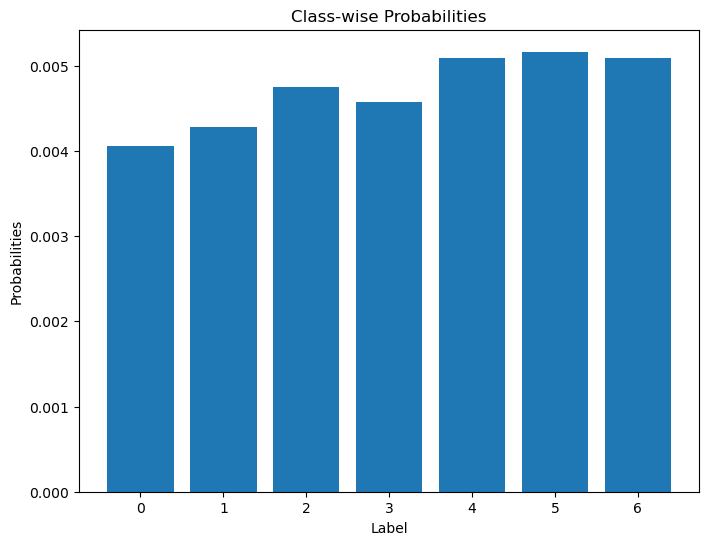

In [28]:
# Set the model to evaluation mode
model.eval()

# Ensure 'input_data' is a tensor and add a batch dimension
input_data = torch.tensor(X_train, dtype=torch.float).unsqueeze(0)
# Get the model's predictions
with torch.no_grad():
    output = model(input_data)

# Calculate class probabilities using softmax
class_probabilities = torch.softmax(output, dim=1).numpy()[0]

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(class_probabilities,axis=1)

mismatch_indices = np.where(predicted_class != y_train)[0]
idx = 34
print("Predicted Class Label : ",predicted_class[idx])
print("Correct Class Label : ",y_train[idx])

# Create a new array with mismatched values
plt.figure(figsize=(8, 6))
plt.bar(range(num_classes),class_probabilities[idx])
plt.xlabel('Label')
plt.ylabel('Probabilities')
plt.title('Class-wise Probabilities')
plt.show()

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


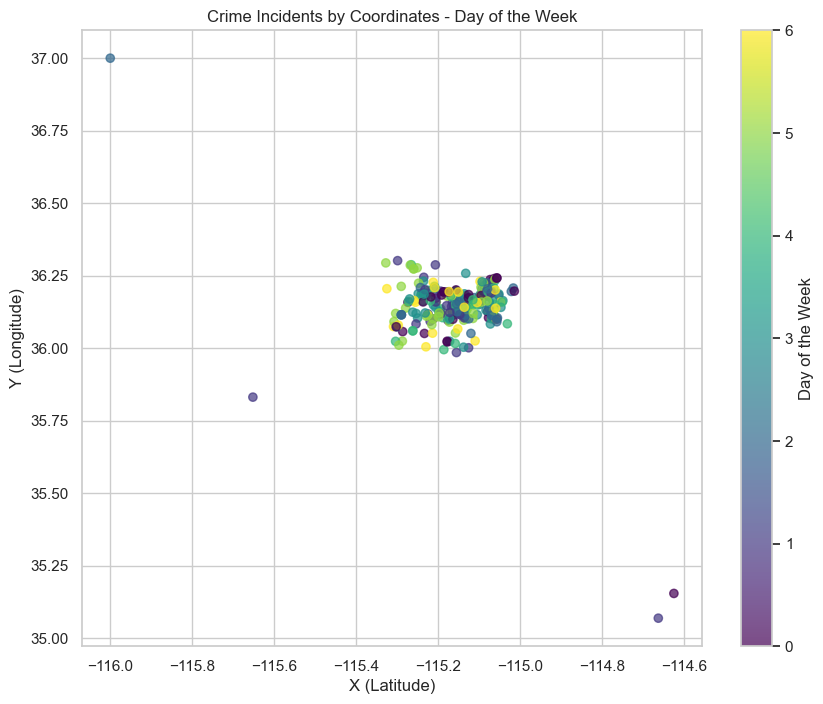

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Scatter plot by coordinates with color indicating the day of the week
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Day of the Week')
plt.title('Crime Incidents by Coordinates - Day of the Week')
plt.xlabel('X (Latitude)')
plt.ylabel('Y (Longitude)')
plt.show()

# After looking at the chart, I can tell that there are few outliners, but most of the victim/ crime scene
# happend in certain area only, the data is not spreaded and most of the crime committed are on weekends.


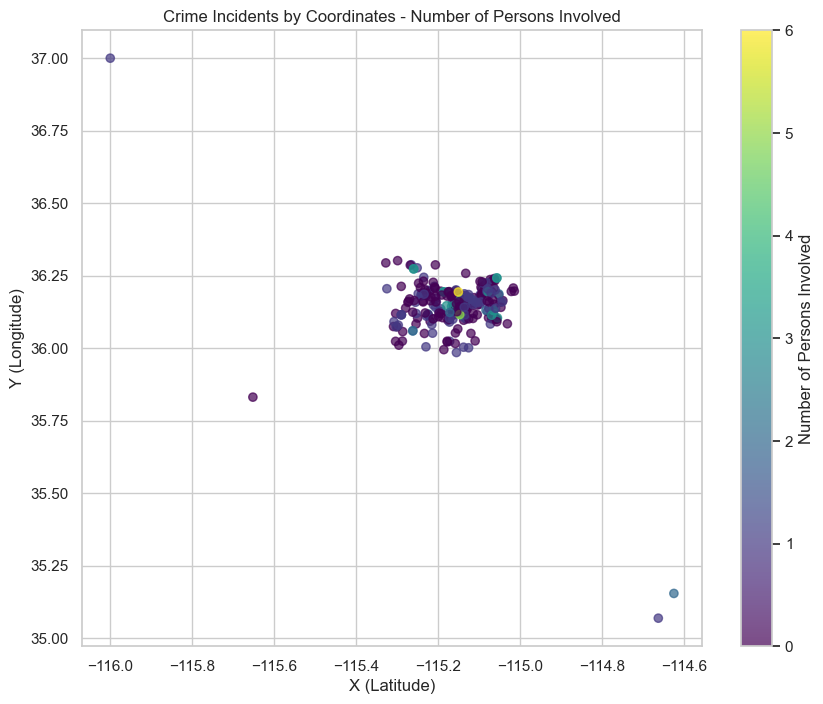

In [31]:

# Scatter plot by coordinates with color indicating the number of persons involved
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Number of Persons Involved')
plt.title('Crime Incidents by Coordinates - Number of Persons Involved')
plt.xlabel('X (Latitude)')
plt.ylabel('Y (Longitude)')
plt.show()

# After looking at the chart, I can tell that there are few outliners, but most of the victim/ crime scene
# happend in certain area only, the number of 0 or 1 victim are more in that region.

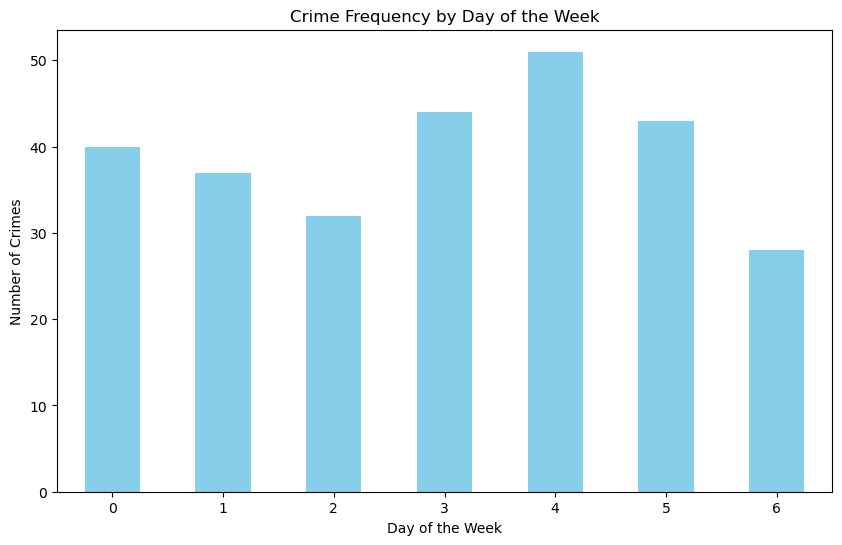

The most frequent day for crimes is: 4


In [30]:

# Sort the number of crimes reported by the day of the week
crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()

# Bar plot for the frequency of crimes by day of the week
plt.figure(figsize=(10, 6))
crime_counts_by_day.plot(kind='bar', color='skyblue')
plt.title('Crime Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)
plt.show()

# Display the days with the most frequent crimes
most_frequent_days = crime_counts_by_day.idxmax()
print(f"The most frequent day for crimes is: {most_frequent_days}")